# Data Import

In [2]:
from utils import auto_wonder_pipeline, process_data_rd, filter

observed_outcome = [
    "Diseases of the circulatory system",
    "Diseases of the respiratory system",
]
short_outcome = ["circulatory system", "respiratory system"]

data = auto_wonder_pipeline(
    observed_outcome=observed_outcome,
    short_outcome=short_outcome,
)

data_65 = auto_wonder_pipeline(
    observed_outcome=observed_outcome,
    short_outcome=short_outcome,
    identifer="65+",
    columns = ["State", "Month Code", "ICD Chapter", "Deaths"]
)

data

cirdeaths       date  resdeaths  totaldeaths
state time                                                    
AK    2010-01-01       78.0 2010-01-01       25.0        103.0
      2010-02-01       74.0 2010-02-01       23.0         97.0
      2010-03-01       64.0 2010-03-01       23.0         87.0
      2010-04-01       75.0 2010-04-01       41.0        116.0
      2010-05-01       62.0 2010-05-01       29.0         91.0
...                     ...        ...        ...          ...
WY    2020-08-01      118.0 2020-08-01       47.0        165.0
      2020-09-01      145.0 2020-09-01       43.0        188.0
      2020-10-01      144.0 2020-10-01       56.0        200.0
      2020-11-01      122.0 2020-11-01       41.0        163.0
      2020-12-01      143.0 2020-12-01       61.0        204.0

[6732 rows x 4 columns]

In [3]:
import pandas as pd
data_ = pd.read_excel('data/ml.xlsx', sheet_name=None)

key_mapper = {
    'FEMA - Major Disaster - Fire': 'fire',
    'FEMA - Major Disaster - Earthqu': 'earthquake',
    'FEMA - Major Disaster - Hurrica': 'hurricane',
    'FEMA - Major Disaster - Tornado': 'tornado',
    'FEMA - Major Disaster - Flood': 'flood',
    }
data_ = {key_mapper.get(old_key, old_key): value for old_key, value in data_.items()}

df_disaster = data_['fire'].loc[:,['State', 'Declaration Date', 'Incident Type']]

from countries_code import code
df_disaster['State'] = df_disaster['State'].map(code)
df_disaster = df_disaster.dropna()
df_disaster.head()

,State,Declaration Date,Incident Type
0,CA,2021-09-12,Fire
1,CA,2021-08-24,Fire
2,WA,2021-02-04,Fire
3,CO,2021-01-15,Fire
4,MT,2021-09-30,Fire


# Data Processing

We don't have data after 2020, so no study is possible

In [4]:
df_disaster = df_disaster[df_disaster["Declaration Date"] < "2020"]

In [5]:
df_temporel = {
    (date, state): process_data_rd(data, state=state, disaster_date=date)
    for date, state in zip(df_disaster["Declaration Date"], df_disaster["State"])
}

df_temporel_65 = {
    (date, state): process_data_rd(data_65, state=state, disaster_date=date)
    for date, state in zip(df_disaster["Declaration Date"], df_disaster["State"])
}


[filter(x) for x in df_temporel.values()]
[filter(x) for x in df_temporel_65.values()]
pass

In [6]:
from typing import Any, List
import pandas as pd
def plot(fig:Any, df: pd.DataFrame, row:int, col:int, disaster_time:str, state: str, category:str, other_events:List[int]):
    # Left y
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df.cirdeaths,
            name="Diseases of the circulatory system",
            mode="markers",
            marker=dict(
                color="rgb(27,158,119)",
            ),
            marker_symbol=symbols[namestems.index("circle-cross")],
            marker_line_width=2,
            marker_size=10,
            # showlegend=False,
        ),
        secondary_y=False,
        row=row,
        col=col,
    )

    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df.cirFiltered,
            marker=dict(
                color="rgb(27,158,119)",
            ),
        ),
        secondary_y=False,
        row=row,
        col=col,
    )
    #Right y
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df.resdeaths,
            name="Diseases of the respiratory system",
            mode="markers",
            marker_symbol=symbols[namestems.index("circle-x")],
            marker=dict(
                color="rgb(297,95,2)",
            ),
            marker_line_width=1.5,
            marker_size=10,
            # showlegend=False,
        ),
        secondary_y=True,
        row=row,
        col=col,
    )

    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df.resFiltered,
            marker=dict(
                color="rgb(297,95,2)",
            ),
        ),
        secondary_y=True,
        row=row,
        col=col,
    )

    # Set x-axis title
    fig.update_xaxes(title_text=f"{disaster_time} in {state} on {category}", range=[-365.0, 365], row=row, col=col)

    # Set y-axes titles
    if col%2:
        fig.update_yaxes(
        title_text='<b style="color:rgb(297,95,2)">Respiratory Axis x</b>',
        secondary_y=True, row=row, col=col,
    )
    else:
        fig.update_yaxes(
            title_text='<b style="color:rgb(27,158,119)">Circulatory axis &#10010;</b> ',
            secondary_y=False, row=row, col=col,
        )
    
    fig.add_vline(x=0.0, line_color="rgb(117,112,79)", line_dash="dash")
    [fig.add_vline(x=shift, line_color="rgb(117,112,79)", line_dash="dash") for shift in other_events]

# Law regressor

## Iterative estimator

In [400]:
import statsmodels.api as sm

import numpy as np


def hist(sx: List[float]):
    """
    Histogram from list of samples
    """

    d = dict()
    for s in sx:
        d[s] = d.get(s, 0) + 1
    return d


converter_ = lambda dict_: (
    np.array(list(dict_.keys())),
    np.array(list(dict_.values())),
)

test = next(iter(df_temporel.values()))
x = test.cirdeaths.astype(int)


x_post = x[x.index > 0]
x_prior = x[x.index < 0]

x_ = {"prior": x_prior, "post": x_post}
hist_ = {k: converter_(hist(v)) for k, v in x_.items()}

# hist(test.cirdeaths)
# used for iterative solutio,n
# s, X = np.array(list(hist_.keys())), np.array(list(hist_.values()))

fit_ = {key: sm.NegativeBinomial(*v).fit() for key, v in hist_.items()}

statistics__ = lambda mu, lambda_: {"r": 1 / lambda_, "p": 1 / (1 + np.exp(mu) * lambda_)}
scores_likehood = {k: v.llf for k, v in fit_.items()}
parameters_likehood = {k: statistics_(*(v.params)) for k, v in fit_.items()}

for key, score in scores_likehood.items():
    print(
            "Log Likehood estimator {} {}".format(
                key, score
            )
        )

Optimization terminated successfully.
         Current function value: 7.879066
         Iterations: 8
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 7.889165
         Iterations: 8
         Function evaluations: 12
         Gradient evaluations: 12
Log Likehood estimator prior -843.0600734070119
Log Likehood estimator post -197.2291366535741


## Moment method

In [396]:
from scipy.stats import nbinom

# used in moments estimator


# pandas method with bias n-1 correction
moments_ = {key: (data.mean(), data.var()) for key, data in x_.items()}
# return (p,r) moment estimation
statistics_ = lambda mean, var: {
    "r": mean ** 2 / (var - mean),
    "p": mean / var,
}  # estimate (r,p)
parameters_moments = {k: statistics_(*v) for k, v in moments_.items()}

for key, parameters_nbin in parameters_moments.items():
    r, p = parameters_nbin['r'], parameters_nbin['p']
    print(
        "Log Likehood estimator {} {}".format(
            key, x.map(lambda val: nbinom.logpmf(val, r, p)).sum()
        )
    )

Log Likehood estimator prior -1052.557637627624
Log Likehood estimator post -1095.7373557387073


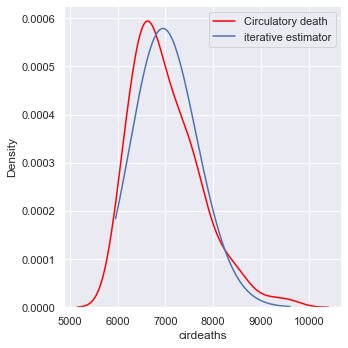

In [307]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.displot(x, kind="kde", label="Circulatory death", color="red")
#plt.plot(x_plot, nbinom.pmf(x_plot, r, p), label="moment estimator")
plt.plot(x_plot, nbinom.pmf(x_plot, n_, p_), label="iterative estimator")
plt.legend()

In [334]:
nbinom.cdf(x, n_, p_)

array([0.01003743, 0.01008291, 0.01012857, ..., 0.98990988, 0.98994345,
       0.98997693])

In [336]:
from scipy.stats import kstest

#nbinom.qr(0.01, n_, p_)


x = np.arange(nbinom.ppf(0.01, n_, p_), nbinom.ppf(0.99, n_, p_))



kstest(x_["prior"], lambda x: nbinom.cdf(x, n_, p_)),kstest(x_["post"], lambda x: nbinom.pmf(x, n_, p_))

(KstestResult(statistic=0.1782343745512231, pvalue=0.0019123405805214098),
 KstestResult(statistic=0.9999985709599103, pvalue=1.5036276652740686e-146))

(array([0.00836901, 0.05021409, 0.17993381, 0.24270141, 0.38079015,
        0.3514986 , 0.26780846, 0.15482676, 0.02510704, 0.01255352]),
 array([-2.92717729, -2.32973536, -1.73229343, -1.13485151, -0.53740958,
         0.06003234,  0.65747427,  1.25491619,  1.85235812,  2.44980004,
         3.04724197]),
 <BarContainer object of 10 artists>)

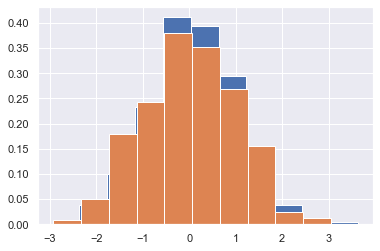

In [365]:
y_plot = np.linspace(-4,4,100)
plt.hist(y, density=True)
plt.hist(norm.rvs(size=400), density=True)
#plt.plot(y_plot, norm.pdf(y_plot))

In [362]:
norm.rvs(size=40)

array([ 1.42836472e+00,  5.72532053e-02, -1.23573020e+00,  4.02214229e-02,
        5.10724258e-01, -1.01262613e+00,  5.40550431e-01, -2.12967368e-01,
        1.11695898e+00, -6.93835465e-04, -1.29000408e+00, -2.00073988e+00,
        9.62935675e-01,  1.93433610e+00, -1.23500816e+00, -6.68339147e-01,
       -1.22259193e+00,  6.88567959e-01, -6.29612505e-01, -2.09090334e-01,
        1.03184150e+00, -1.90342871e+00, -6.71773585e-01, -1.36206519e+00,
        3.87074439e-01,  2.49084439e-02,  1.58554321e+00, -2.33696993e+00,
       -4.83906853e-01,  9.89783012e-01,  4.45570078e-01,  5.91255952e-01,
        5.83723129e-01,  6.11123244e-01,  8.35695918e-01,  3.35021084e-01,
        2.08591508e+00,  6.30535240e-01,  2.40433524e-01,  1.17679038e+00])

In [381]:
kstest(y, lambda x: norm.cdf(x))

KstestResult(statistic=0.07736336120825843, pvalue=0.05225097077412799)

In [388]:
from scipy.stats import norm
y = np.random.normal(size=(300000,))
kstest(y, lambda x: norm.cdf(x))

KstestResult(statistic=0.0021927140990781746, pvalue=0.1115495654991775)

<AxesSubplot:>

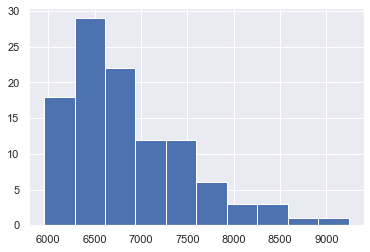

In [318]:
x_["prior"].hist()

# Application of iterative estimator

In [7]:
import numpy as np

from plotly.subplots import make_subplots
from plotly.validators.scatter.marker import SymbolValidator
import plotly.graph_objects as go
from typing import Dict

raw_symbols = SymbolValidator().values
namestems = []
namevariants = []
symbols = []
for i in range(0, len(raw_symbols), 3):
    name = raw_symbols[i + 2]
    symbols.append(raw_symbols[i])
    namestems.append(name.replace("-open", "").replace("-dot", ""))
    namevariants.append(name[len(namestems[-1]) :])

# def plot(df_temporel: Dict[pd.Timestamp: pd.DataFrame]):
"""Plot at each row death count in each category.

Args:
df_temporel (_type_): _description_
"""
rows = 3#len(df_temporel)
cols = 2


# Create figure with secondary y-axis
fig = make_subplots(
    rows=rows,
    cols=2,
    specs=[[{"secondary_y": True}, {"secondary_y": True}] for _ in range(rows)],
)

liste_ = list(df_temporel.keys())[:rows]
from tqdm import tqdm
for row, (date, state) in enumerate(tqdm(liste_), start=1):
    shifts=[]
    max_shift = 365
    k = row-1
    
    time = str(date).split(" ")[0]
    for i in list(range(k-1,-1,-1))+list(range(k+1,len(liste_))):
        neighbor_time, neighbor_state = liste_[i]
        if neighbor_state==state:
            shifts.append(int((neighbor_time-pd.to_datetime(time))/ np.timedelta64(1, "D")))
        
    for col in [1, 2]:
        plot(
            fig=fig,
            df=df_temporel[(date, state)] if col % 2 else df_temporel_65[(date, state)],
            row=row,
            col=col,
            disaster_time=time,
            state=state,
            other_events=shifts,
            category= "all" if col % 2 else "65+"
        )


fig.update_layout(title_text="Fire disasters", height= 1000*rows/3,plot_bgcolor='white')
fig.update_traces(showlegend=False)

# fig.update(layout_xaxis_range = [-365,365])

fig.show()

100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


In [103]:
fig.write_html("ml.html")

In [104]:
fig.write_image("ml.png")

In [81]:
liste_ = list(df_temporel.keys())

k = 3
time = '2018-06-25'
state = 'CA'

shifts=[]

max_shift = 365

for i in list(range(k-1,-1,-1))+list(range(k+1,len(liste_))):
    neighbor_time, neighbor_state = liste_[i]
    if neighbor_state==state:
        shifts.append(int((neighbor_time-pd.to_datetime(time))/ np.timedelta64(1, "D")))
        

In [91]:
import numpy as np

int((neighbor_time-pd.to_datetime(time))/ np.timedelta64(1, "D"))

-2188

In [67]:
for i in range(0-1,-1,-1):
    print(i)

In [70]:
list(range(0,5,2))

[0, 2, 4]

In [50]:
list(df_temporel.keys())[:3]

[(Timestamp('2018-11-12 00:00:00'), 'CA'),
 (Timestamp('2018-08-04 00:00:00'), 'CA'),
 (Timestamp('2018-01-02 00:00:00'), 'CA')]

In [183]:
fig.layout

Layout({
    'shapes': [{'line': {'color': 'rgb(117,112,79)', 'dash': 'dash'},
                'type': 'line',
                'x0': 0.0,
                'x1': 0.0,
                'xref': 'x',
                'y0': 0,
                'y1': 1,
                'yref': 'y domain'},
               {'line': {'color': 'rgb(117,112,79)', 'dash': 'dash'},
                'type': 'line',
                'x0': 0.0,
                'x1': 0.0,
                'xref': 'x',
                'y0': 0,
                'y1': 1,
                'yref': 'y domain'},
               {'line': {'color': 'rgb(117,112,79)', 'dash': 'dash'},
                'type': 'line',
                'x0': 0.0,
                'x1': 0.0,
                'xref': 'x2',
                'y0': 0,
                'y1': 1,
                'yref': 'y3 domain'},
               {'line': {'color': 'rgb(117,112,79)', 'dash': 'dash'},
                'type': 'line',
                'x0': 0.0,
                'x1': 0.0,
                '

In [175]:
fig2 = make_subplots(
    rows=2, cols=1, specs = (
            [[{"secondary_y": True} for _ in range(1)] for _ in range(2)]
        )
)

fig2.add_trace(fig,
              row=1, col=1)

fig2.add_trace(fig, row=2, col=1)



fig2.show()

ValueError: 
    Invalid element(s) received for the 'data' property of 
        Invalid elements include: [Figure({
    'data': [{'marker': {'color': 'rgb(27,158,119)', 'line': {'width': 2}, 'size': 10, 'symbol': 27},
              'mode': 'markers',
              'name': 'Diseases of the circulatory system',
              'showlegend': False,
              'type': 'scatter',
              'x': array([-3237, -3206, -3178, -3147, -3117, -3086, -3056, -3025, -2994, -2964,
                          -2933, -2903, -2872, -2841, -2813, -2782, -2752, -2721, -2691, -2660,
                          -2629, -2599, -2568, -2538, -2507, -2476, -2447, -2416, -2386, -2355,
                          -2325, -2294, -2263, -2233, -2202, -2172, -2141, -2110, -2082, -2051,
                          -2021, -1990, -1960, -1929, -1898, -1868, -1837, -1807, -1776, -1745,
                          -1717, -1686, -1656, -1625, -1595, -1564, -1533, -1503, -1472, -1442,
                          -1411, -1380, -1352, -1321, -1291, -1260, -1230, -1199, -1168, -1138,
                          -1107, -1077, -1046, -1015,  -986,  -955,  -925,  -894,  -864,  -833,
                           -802,  -772,  -741,  -711,  -680,  -649,  -621,  -590,  -560,  -529,
                           -499,  -468,  -437,  -407,  -376,  -346,  -315,  -284,  -256,  -225,
                           -195,  -164,  -134,  -103,   -72,   -42,   -11,    19,    50,    81,
                            109,   140,   170,   201,   231,   262,   293,   323,   354,   384,
                            415,   446,   475,   506,   536,   567,   597,   628,   659,   689,
                            720,   750]),
              'xaxis': 'x',
              'y': array([7313., 6610., 7177., 6692., 6683., 6118., 6194., 6150., 5994., 6360.,
                          6601., 7068., 7627., 6923., 7437., 6766., 6588., 6307., 6239., 6158.,
                          5969., 6195., 6608., 7492., 7361., 6919., 7331., 6829., 6673., 6107.,
                          6299., 6231., 6018., 6541., 6860., 7204., 8506., 7522., 7533., 6506.,
                          6415., 6160., 6223., 6381., 5956., 6568., 6535., 7300., 7650., 6475.,
                          6935., 6460., 6580., 6127., 6296., 6123., 6210., 6444., 6516., 7433.,
                          8580., 7085., 7442., 6904., 7065., 6579., 6462., 6508., 6216., 6556.,
                          7181., 7767., 8104., 7608., 7798., 7079., 6774., 6546., 6494., 6591.,
                          6519., 6906., 6810., 8139., 8896., 7540., 7920., 7127., 7141., 6921.,
                          6661., 6472., 6703., 6820., 6827., 8531., 9240., 7404., 8198., 7253.,
                          6977., 6723., 6824., 6679., 6356., 6770., 7007., 7851., 8246., 7691.,
                          8286., 7315., 7271., 6913., 6720., 6583., 6538., 7014., 7032., 7972.,
                          8520., 7622., 7951., 7706., 7550., 7122., 7530., 7606., 7156., 7259.,
                          7819., 9614.]),
              'yaxis': 'y'},
             {'marker': {'color': 'rgb(27,158,119)'},
              'showlegend': False,
              'type': 'scatter',
              'x': array([-3237, -3206, -3178, -3147, -3117, -3086, -3056, -3025, -2994, -2964,
                          -2933, -2903, -2872, -2841, -2813, -2782, -2752, -2721, -2691, -2660,
                          -2629, -2599, -2568, -2538, -2507, -2476, -2447, -2416, -2386, -2355,
                          -2325, -2294, -2263, -2233, -2202, -2172, -2141, -2110, -2082, -2051,
                          -2021, -1990, -1960, -1929, -1898, -1868, -1837, -1807, -1776, -1745,
                          -1717, -1686, -1656, -1625, -1595, -1564, -1533, -1503, -1472, -1442,
                          -1411, -1380, -1352, -1321, -1291, -1260, -1230, -1199, -1168, -1138,
                          -1107, -1077, -1046, -1015,  -986,  -955,  -925,  -894,  -864,  -833,
                           -802,  -772,  -741,  -711,  -680,  -649,  -621,  -590,  -560,  -529,
                           -499,  -468,  -437,  -407,  -376,  -346,  -315,  -284,  -256,  -225,
                           -195,  -164,  -134,  -103,   -72,   -42,   -11,    19,    50,    81,
                            109,   140,   170,   201,   231,   262,   293,   323,   354,   384,
                            415,   446,   475,   506,   536,   567,   597,   628,   659,   689,
                            720,   750]),
              'xaxis': 'x',
              'y': array([6724.28029056, 6709.5626046 , 6695.21286846, 6681.53680533,
                          6669.14125536, 6658.63959819, 6650.65387517, 6645.46822793,
                          6643.0813894 , 6643.18242488, 6645.0547238 , 6647.80468656,
                          6650.51117938, 6652.51569053, 6653.77001382, 6654.39499574,
                          6655.0010015 , 6656.26814946, 6658.83468237, 6663.12055034,
                          6669.28330685, 6677.16480501, 6686.16922087, 6695.39937748,
                          6703.90924212, 6711.25065746, 6717.3861479 , 6722.40808118,
                          6726.79233368, 6731.08140176, 6735.78416154, 6741.01943828,
                          6746.63306714, 6752.15212113, 6756.64827758, 6759.06124377,
                          6758.39532178, 6753.93290043, 6746.04862146, 6735.59716854,
                          6723.92506996, 6712.23535577, 6701.53797787, 6692.49774104,
                          6685.48036384, 6680.65687873, 6677.74239296, 6676.38160321,
                          6676.12999218, 6676.93280406, 6679.34395179, 6683.79114033,
                          6690.86185964, 6701.00373024, 6714.59508397, 6731.65550036,
                          6751.94293699, 6774.83494177, 6799.37034826, 6824.3812182 ,
                          6848.52250685, 6870.8295562 , 6891.41988169, 6910.54485527,
                          6928.79996149, 6946.77659434, 6965.15127284, 6984.37065566,
                          7004.56693188, 7025.57455897, 7046.73514004, 7067.09679409,
                          7085.79155569, 7102.38889889, 7117.09467802, 7130.43075436,
                          7143.34455501, 7156.75136284, 7171.33562037, 7187.40005055,
                          7204.82404154, 7223.11423146, 7241.34861844, 7258.40700417,
                          7272.89959749, 7283.98697785, 7291.84416245, 7296.80617662,
                          7299.60064311, 7300.8490558 , 7301.07378315, 7300.55978799,
                          7299.19198702, 7296.33744707, 7290.99061498, 7281.84822669,
                          7267.31702401, 7246.58446859, 7220.07094895, 7188.29523834,
                          7152.38731562, 7113.51760017, 7072.74689427, 7030.89192671,
                          6988.61395947, 6946.35432208, 6904.15896035, 7531.96923904,
                          7508.17533095, 7484.58081708, 7461.84623208, 7440.76112258,
                          7422.63013132, 7408.67930034, 7400.03990284, 7397.53341247,
                          7401.55627792, 7411.99586451, 7428.19981489, 7449.2670243 ,
                          7474.04876307, 7501.72300967, 7532.12146207, 7565.15099137,
                          7600.98026775, 7639.86599203, 7682.03300236, 7727.38247064,
                          7775.72054815, 7826.77752211, 7879.89635442, 7934.06514601]),
              'yaxis': 'y'},
             {'marker': {'color': 'rgb(297,95,2)', 'line': {'width': 1.5}, 'size': 10, 'symbol': 28},
              'mode': 'markers',
              'name': 'Diseases of the respiratory system',
              'showlegend': False,
              'type': 'scatter',
              'x': array([-3237, -3206, -3178, -3147, -3117, -3086, -3056, -3025, -2994, -2964,
                          -2933, -2903, -2872, -2841, -2813, -2782, -2752, -2721, -2691, -2660,
                          -2629, -2599, -2568, -2538, -2507, -2476, -2447, -2416, -2386, -2355,
                          -2325, -2294, -2263, -2233, -2202, -2172, -2141, -2110, -2082, -2051,
                          -2021, -1990, -1960, -1929, -1898, -1868, -1837, -1807, -1776, -1745,
                          -1717, -1686, -1656, -1625, -1595, -1564, -1533, -1503, -1472, -1442,
                          -1411, -1380, -1352, -1321, -1291, -1260, -1230, -1199, -1168, -1138,
                          -1107, -1077, -1046, -1015,  -986,  -955,  -925,  -894,  -864,  -833,
                           -802,  -772,  -741,  -711,  -680,  -649,  -621,  -590,  -560,  -529,
                           -499,  -468,  -437,  -407,  -376,  -346,  -315,  -284,  -256,  -225,
                           -195,  -164,  -134,  -103,   -72,   -42,   -11,    19,    50,    81,
                            109,   140,   170,   201,   231,   262,   293,   323,   354,   384,
                            415,   446,   475,   506,   536,   567,   597,   628,   659,   689,
                            720,   750]),
              'xaxis': 'x',
              'y': array([2268., 2045., 2407., 2000., 1896., 1633., 1599., 1596., 1550., 1591.,
                          1739., 2020., 2345., 2282., 2526., 1986., 1914., 1814., 1686., 1595.,
                          1529., 1685., 1767., 2181., 2275., 2136., 2347., 2024., 1853., 1665.,
                          1670., 1611., 1529., 1610., 1819., 2140., 2976., 2785., 2456., 2011.,
                          1799., 1647., 1658., 1611., 1570., 1796., 1829., 2170., 2953., 2207.,
                          2021., 1877., 1779., 1633., 1690., 1633., 1572., 1585., 1737., 2010.,
                          2904., 2505., 2335., 2092., 1933., 1841., 1657., 1619., 1629., 1687.,
                          1781., 2230., 2512., 2423., 2579., 2066., 1938., 1619., 1775., 1593.,
                          1653., 1759., 1857., 2339., 3132., 2437., 2438., 2110., 2057., 1840.,
                          1708., 1647., 1631., 1676., 1740., 2494., 3918., 2526., 2686., 2087.,
                          1885., 1697., 1661., 1623., 1537., 1598., 1826., 2114., 2487., 2222.,
                          2506., 2051., 1883., 1815., 1679., 1565., 1490., 1823., 1778., 2137.,
                          2626., 2471., 2564., 2116., 1754., 1605., 1745., 1643., 1537., 1563.,
                          1703., 2113.]),
              'yaxis': 'y2'},
             {'marker': {'color': 'rgb(297,95,2)'},
              'showlegend': False,
              'type': 'scatter',
              'x': array([-3237, -3206, -3178, -3147, -3117, -3086, -3056, -3025, -2994, -2964,
                          -2933, -2903, -2872, -2841, -2813, -2782, -2752, -2721, -2691, -2660,
                          -2629, -2599, -2568, -2538, -2507, -2476, -2447, -2416, -2386, -2355,
                          -2325, -2294, -2263, -2233, -2202, -2172, -2141, -2110, -2082, -2051,
                          -2021, -1990, -1960, -1929, -1898, -1868, -1837, -1807, -1776, -1745,
                          -1717, -1686, -1656, -1625, -1595, -1564, -1533, -1503, -1472, -1442,
                          -1411, -1380, -1352, -1321, -1291, -1260, -1230, -1199, -1168, -1138,
                          -1107, -1077, -1046, -1015,  -986,  -955,  -925,  -894,  -864,  -833,
                           -802,  -772,  -741,  -711,  -680,  -649,  -621,  -590,  -560,  -529,
                           -499,  -468,  -437,  -407,  -376,  -346,  -315,  -284,  -256,  -225,
                           -195,  -164,  -134,  -103,   -72,   -42,   -11,    19,    50,    81,
                            109,   140,   170,   201,   231,   262,   293,   323,   354,   384,
                            415,   446,   475,   506,   536,   567,   597,   628,   659,   689,
                            720,   750]),
              'xaxis': 'x',
              'y': array([2000.67012286, 1986.39411215, 1972.28518263, 1958.54704413,
                          1945.65510326, 1934.11067475, 1924.38403887, 1916.75728171,
                          1911.30912434, 1907.91781456, 1906.23578191, 1905.71738236,
                          1905.71244946, 1905.64224343, 1905.2025792 , 1904.32449529,
                          1903.32702862, 1902.5802633 , 1902.46095404, 1903.29049289,
                          1905.2549838 , 1908.34784916, 1912.327352  , 1916.81216295,
                          1921.33012303, 1925.57419068, 1929.45836798, 1933.02817317,
                          1936.59008801, 1940.50745162, 1945.09135936, 1950.4807144 ,
                          1956.64248781, 1963.33147524, 1970.03519577, 1976.02033629,
                          1980.45918672, 1982.62652427, 1982.41933912, 1980.23610493,
                          1976.77128322, 1972.73856298, 1968.74052614, 1965.17616801,
                          1962.25027109, 1959.94625777, 1958.00239402, 1956.0544794 ,
                          1953.65768697, 1950.50090575, 1946.8976137 , 1943.3216007 ,
                          1940.29297064, 1938.29037641, 1937.69166279, 1938.68386806,
                          1941.29922322, 1945.37890688, 1950.53328558, 1956.14748909,
                          1961.47318886, 1965.79571416, 1968.98947351, 1971.26587812,
                          1973.06509578, 1974.90275309, 1977.26943598, 1980.57204116,
                          1985.01729692, 1990.58594907, 1997.03623256, 2003.93664115,
                          2010.72064594, 2016.96300765, 2022.55178657, 2027.62881614,
                          2032.6837099 , 2038.23006341, 2044.72229488, 2052.35280377,
                          2061.14541307, 2070.83685029, 2080.90875205, 2090.64785693,
                          2099.20096054, 2105.8700786 , 2110.60272622, 2113.55337469,
                          2115.08111863, 2115.54283177, 2115.25908717, 2114.37824359,
                          2112.79412288, 2110.10843549, 2105.62177054, 2098.36339935,
                          2087.13407969, 2070.98184215, 2050.09900855, 2024.96228705,
                          1996.44582394, 1965.46253907, 1932.85569864, 1899.30077979,
                          1865.30334983, 1831.19628808, 1797.10728428, 2174.24751184,
                          2152.2018189 , 2130.11847128, 2108.16906312, 2086.58261456,
                          2065.83679006, 2046.38701494, 2028.57444153, 2012.59560529,
                          1998.42855762, 1985.7716027 , 1974.00527685, 1962.40838414,
                          1950.13722533, 1936.45722096, 1921.05620579, 1903.95610381,
                          1885.58067891, 1866.48622238, 1847.14678762, 1827.87299911,
                          1808.9116396 , 1790.39394623, 1772.28121134, 1754.39260608]),
              'yaxis': 'y2'}],
    'layout': {'shapes': [{'line': {'color': 'rgb(117,112,79)', 'dash': 'dash'},
                           'type': 'line',
                           'x0': 0.0,
                           'x1': 0.0,
                           'xref': 'x',
                           'y0': 0,
                           'y1': 1,
                           'yref': 'y domain'}],
               'template': '...',
               'title': {'text': 'Disaster from:'},
               'xaxis': {'anchor': 'y',
                         'domain': [0.0, 0.94],
                         'range': [-700.0, 700],
                         'title': {'text': 'Days from disaster'}},
               'yaxis': {'anchor': 'x',
                         'domain': [0.0, 1.0],
                         'title': {'text': '<b style="color:rgb(27,158,119)">Circulatory axis &#10010;</b> '}},
               'yaxis2': {'anchor': 'x',
                          'overlaying': 'y',
                          'side': 'right',
                          'title': {'text': '<b style="color:rgb(297,95,2)">Respiratory Axis x</b>'}}}
})]

    The 'data' property is a tuple of trace instances
    that may be specified as:
      - A list or tuple of trace instances
        (e.g. [Scatter(...), Bar(...)])
      - A single trace instance
        (e.g. Scatter(...), Bar(...), etc.)
      - A list or tuple of dicts of string/value properties where:
        - The 'type' property specifies the trace type
            One of: ['bar', 'barpolar', 'box', 'candlestick',
                     'carpet', 'choropleth', 'choroplethmapbox',
                     'cone', 'contour', 'contourcarpet',
                     'densitymapbox', 'funnel', 'funnelarea',
                     'heatmap', 'heatmapgl', 'histogram',
                     'histogram2d', 'histogram2dcontour', 'icicle',
                     'image', 'indicator', 'isosurface', 'mesh3d',
                     'ohlc', 'parcats', 'parcoords', 'pie',
                     'pointcloud', 'sankey', 'scatter',
                     'scatter3d', 'scattercarpet', 'scattergeo',
                     'scattergl', 'scattermapbox', 'scatterpolar',
                     'scatterpolargl', 'scattersmith',
                     'scatterternary', 'splom', 'streamtube',
                     'sunburst', 'surface', 'table', 'treemap',
                     'violin', 'volume', 'waterfall']

        - All remaining properties are passed to the constructor of
          the specified trace type

        (e.g. [{'type': 'scatter', ...}, {'type': 'bar, ...}])

In [2]:
from wonder_utils import DataPloter

from typing import Dict, List, Any
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import pandas as pd
import numpy as np
import os


class Death_Data(DataPloter):
    """
    Available features to select:
        state, month, age_category, ICD chapter

    Available features to plot:
        deaths, suicide_proportion, suicide_per_100k

    The data pipeline works as following:"""

    def __init__(
        self,
        data_folder: str = "Data",
        indexer_columns: List[str] = [
            "state",
            "date",
            "age_group",
            "icd",
        ],
        drop_cols: List[str] = [
            "Year Code",
            "State Code",
            "Month",  # keep month code
            "ICD Chapter Code",
            "UCD - ICD Chapter Code",
            "Crude Rate",
        ],
        reject_list: List[str] = ["test"],
    ) -> None:

        super(Death_Data, self).__init__(
            data_folder=data_folder,
            indexer_columns=indexer_columns,
            drop_cols=drop_cols,
            reject_list=reject_list,
        )

    def file_to_dataframe(
        self,
        data_folder: str,
        file: str,
        rename_mapper: Dict[str, str] = {
            "Month Code": "date",
            "ICD Chapter": "icd",
            "UCD - ICD Chapter": "icd",
            "Deaths": "deaths",
        },
    ) -> pd.DataFrame:
        """CDC Wonder txt file into dataframe
        Args:
            data_folder (str): where the data files are stored
            file (str): file that we want to process
            rename_mapper (_type_, optional): dictionnary to rename
                the columns.
                Defaults to {"Single Race 6": "race",
                             "Race": "race",
                             "Gender": "gender",
                             "Residence HHS Region Code": "hhs",
                             "HHS Region Code": "hhs",
                             "Population": "population",
                             "Year": "year", "Deaths": "deaths",
                             "Hispanic Origin": "ethnicity",
                             "Age Adjusted Rate": "age_adjusted_rate",}.

        Returns:
            pd.DataFrame: converted file into a pandas dataframe
        """
        process_line = lambda line: line.strip().replace('"', "").split("\t")

        lines = []
        with open(f"{data_folder}/{file}", "r") as f:
            for line in iter(lambda: f.readline().rstrip(), '"---"'):
                #CDC wonder add a total line despite we did not ask, 
                #ading one column sometime and breaking the pipeline
                if "Total" in line:
                    continue
                lines.append(process_line(line))
        # column is on the header, remove corner named notes
        res = pd.DataFrame(lines[1:], columns=lines[0][1:]).rename(
            columns=rename_mapper
        )
        # If Age Adjusted Rate is missing, fill with NaN
        if "age_adjusted_rate" not in res.columns:
            res["age_adjusted_rate"] = np.nan
        return res

    def processor(
        self,
        x: pd.DataFrame,
        force_numeric: List[str] = ["population", "Crude Rate"],
    ) -> pd.DataFrame:
        """Process dataframes: convert columns dtype, compute new features.
        Args:
            x (pd.DataFrame): dataframe that we want to process
            force_numeric (List[str], optional): force these columns
                into numerical columns.
                Defaults to ["population", "Crude Rate"].

        Returns:
            pd.DataFrame: processed dataframe

        """

        # Automatically convert numeric columns to float/int type
        if self.numeric_columns.empty:
            self.numeric_columns = x.apply(
                lambda s: pd.to_numeric(s.replace(np.nan, 0), errors="coerce")
                .notnull()
                .all()
            )

            # compare with the force numeric and prevent numeric columns
            self.convert_cols = [
                col
                for col, bool_ in self.numeric_columns.items()
                if (bool_ or col in force_numeric)  # and col != "year"
                # keep year as str to prevent unexpected ticks on plots
            ]

        x.columns = self.numeric_columns.index

        x.date = pd.to_datetime(x.date)#.str.extract("(\d+)")
        # x = x.replace(
        #     {
        #         "Not Hispanic or Latino": "Non-Hispanic",
        #         "Hispanic or Latino": "Hispanic",
        #         "Not Applicable": np.nan,
        #         "Unreliable": np.nan,
        #         "Asian or Pacific Islander": "API",
        #         "Asian": "API",
        #         "Black or African American": "Black",
        #         "Native Hawaiian or Other Pacific Islander": "API",
        #     }
        # )

        x[self.convert_cols] = x[self.convert_cols].apply(
            pd.to_numeric, errors="coerce"
        )
 
        x = x.loc[
            ~pd.concat(
                [x.eq(forbidden).any(axis=1) for forbidden in self.reject_list], axis=1
            ).any(axis=1)
        ]
        return x
        
    

    def load_data(
        self,
        drop_cols: List[str] = [],
        identifier: str = "death",
        data_folder: str = "data/CDC",
    ) -> Dict[str, pd.DataFrame]:
        """
        Automatically load all files containing identifier.
        This method is specific to the suicie_rate project and should be
        rewritten for other projects.

        Args:
            drop_cols (List[str], optional): Select what columns
                should be dropped. Defaults to [].
            identifier (str, optional): used to identify which files
                should be process. Defaults to "Data".

        Returns:
            Dict[str, pd.DataFrame]: dictionnary containing specific
                name of files and its associated dataframe.
        """
        available_files = os.listdir(data_folder)
        raw_data = [file for file in available_files if identifier in file]

        data = {
            (entry.split()[-1].split(".")[0], entry.split()[-2]): entry
            for entry in raw_data
        }

        age_strats = set(key[0] for key in data.keys())  # {'10-19', 'Overall', ...}

        dataframes = {
            age_strat: pd.concat(
                map(
                    self.processor,
                    [
                        self.file_to_dataframe(self.data_folder, file).assign(
                            age_strat=age_strat
                        )
                        for key_tuple, file in data.items()
                        if key_tuple[0] == age_strat
                    ],
                ),
                axis=0,
            )#.drop(columns=[x for x in drop_cols)
            for age_strat in age_strats
        }
        
        print("o")
        
        return {key: df.drop(df.filter(drop_cols), axis=1) for key, df in dataframes.items()}


test = Death_Data(data_folder="data/CDC")

o


In [11]:
disaster_date = "2015-09-01"
dd[dd.date=="disaster_date"]

,State,date,icd,deaths,Population,age_adjusted_rate,age_strat


In [15]:
dd.dtypes

State                        object
date                 datetime64[ns]
icd                          object
deaths                        int64
Population                   object
age_adjusted_rate           float64
age_strat                    object
dtype: object

In [5]:
dd = test.data['all']

In [ ]:
numeric_columns = []
def processor(
        x: pd.DataFrame,
        force_numeric: List[str] = ["population", "Crude Rate"],
    ) -> pd.DataFrame:
        """Process dataframes: convert columns dtype, compute new features.
        Args:
            x (pd.DataFrame): dataframe that we want to process
            force_numeric (List[str], optional): force these columns
                into numerical columns.
                Defaults to ["population", "Crude Rate"].

        Returns:
            pd.DataFrame: processed dataframe

        """

        # Automatically convert numeric columns to float/int type
        if numeric_columns.empty:
            numeric_columns = x.apply(
                lambda s: pd.to_numeric(s.replace(np.nan, 0), errors="coerce")
                .notnull()
                .all()
            )

            # compare with the force numeric and prevent numeric columns
            convert_cols = [
                col
                for col, bool_ in self.numeric_columns.items()
                if (bool_ or col in force_numeric)  # and col != "year"
                # keep year as str to prevent unexpected ticks on plots
            ]

        x.columns = numeric_columns.index

        x.date = x.date#.str.extract("(\d+)")
      
        x[convert_cols] = x[convert_cols].apply(
            pd.to_numeric, errors="coerce"
        )

        #x = x.loc[
        #    ~pd.concat(
        #        [x.eq(forbidden).any(axis=1) for forbidden in self.reject_list], axis=1
        #    ).any(axis=1)
        #]

['death 2010_2015 all.txt',
 'death 2010_2015 65+.txt',
 'death 2016_2017 all.txt',
 'death 2016_2017 65+.txt',
 'death 2018_2020 all.txt',
 'death 2018_2020 65+.txt']

In [ ]:
data_folder = "data/CDC"

available_files = os.listdir(data_folder)
raw_data = [file for file in available_files if "death" in file]
drop_cols = []

data = {
    (entry.split()[-1].split(".")[0], entry.split()[-2]): entry
    for entry in raw_data
}

age_strats = set(key[0] for key in data.keys()) 

dataframes = {
    age_strat: pd.concat(
        map(
            processor,
            [
                self.file_to_dataframe(self.data_folder, file).assign(
                    age_strat=age_strat
                )
                for key_tuple, file in data.items()
                if key_tuple[0] == age_strat
            ],
        ),
        axis=0,
    ).drop(columns=drop_cols)
    for age_strat in age_strats
}

with open(f"{data_folder}/{file}", "r") as f:
            for line in iter(lambda: f.readline().rstrip(), '"---"'):
                #CDC wonder add a total line despite we did not ask, 
                #ading one column sometime and breaking the pipeline
                if "Total" in line:
                    continue
                lines.append(process_line(line))
        # column is on the header, remove corner named notes
        res = pd.DataFrame(lines[1:], columns=lines[0][1:]).rename(
            columns=rename_mapper
        )
        # If Age Adjusted Rate is missing, fill with NaN
        if "age_adjusted_rate" not in res.columns:
            res["age_adjusted_rate"] = np.nan
        return res

NameError: name 'self' is not defined

In [ ]:
res = []
for file in raw_data:
  
    process_line = lambda line: line.strip().replace('"', "").split("\t")
    rename_mapper = {
                "Month Code": "date",
                "ICD Chapter": "icd",
                "Deaths": "deaths",
                "UCD - ICD Chapter": "UCD - ICD Chapter Code",
            }
    lines = []
    with open(f"{data_folder}/{file}", "r") as f:
        for line in iter(lambda: f.readline().rstrip(), '"---"'):
            if "Total" in line:
                continue
            lines.append(process_line(line))
    # column is on the header, remove corner named notes
    res.append(pd.DataFrame(lines[1:], columns=lines[0][1:]))#.rename(
       # columns=rename_mapper
    #)

 

In [ ]:
file = raw_data[2]
process_line = lambda line: line.strip().replace('"', "").split("\t")
rename_mapper = {
            "Month Code": "date",
            "ICD Chapter": "icd",
            "Deaths": "deaths",
            "UCD - ICD Chapter": "UCD - ICD Chapter Code",
        }
lines = []
with open(f"{data_folder}/{file}", "r") as f:
    i=0
    for line in iter(lambda: f.readline().rstrip(), '"---"'):
        lines.append(process_line(line))
        i+=1
        if i == 5:
            break
line

'\t"Alabama"\t"01"\t"Jan., 2016"\t"2016/01"\t"Endocrine, nutritional and metabolic diseases"\t"E00-E88"\t194\tNot Applicable\tNot Applicable'